# ES 100 Peak Finder Script

### Daniel Galindo-Navarro

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


## Helper Functions and Modules Imported

In [4]:
#your answers here
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import scipy
import peakutils
from peakutils.plot import plot as pplot
from mpl_toolkits.mplot3d import Axes3D
import time

# Experimental set up and data-taking procedure described in folder's attached Test Procedure.
import csv

# function to more easily select which range of data to display
def plotsec(X, Y, xmin, xmax):
    plt.plot(X[xmin:xmax], Y[xmin:xmax])
    fig = plt.gcf()
    fig.set_size_inches(28.5, 8.5)
    
# perform a LOW PASS FILTER using DFT of a signal Y on timescale X, and plot it if isPlot == True.
# returns filtered Y
def LPF(X, Y, cutoff, isPlot):
    # de-mean data of interest
    mean = sum(Y)/float(len(Y))
    Y_noDC = Y
    Y_noDC[:] = [x - mean for x in Y]


    ##### define a frequency axis
    f = np.linspace(-240,240,len(Y_noDC))
    # take DFT
    acc_f = np.fft.fft(Y_noDC)
    # rearrage so that slowest frequencies are in the middle matching your frequency axis
    acc_f = np.roll(acc_f.T,len(Y_noDC)/2)

    # remove high frequency component
    acc_f[abs(f) > cutoff] = 0

    acc_f = np.roll(acc_f, len(Y_noDC)/2)
    Y_clean = np.fft.ifft(acc_f.T)
    # add DC component back
    Y_clean[:] = [x + mean for x in Y_clean]
    
    if isPlot:
        plt.figure(figsize = (16,5))
        plotsec(X, Y_clean, 0, len(X))
        plt.xlabel('Time')
        plt.ylabel('Magnitude')
        plt.title('Filtered Signal')
        plt.show()

    return Y_clean

def randrange(n, vmin, vmax):
    '''
    Source: https://matplotlib.org/examples/mplot3d/scatter3d_demo.html
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

# print sys.executable 

In [ ]:
## THESIS BASELINE SIGNAL AGGREGATION

931


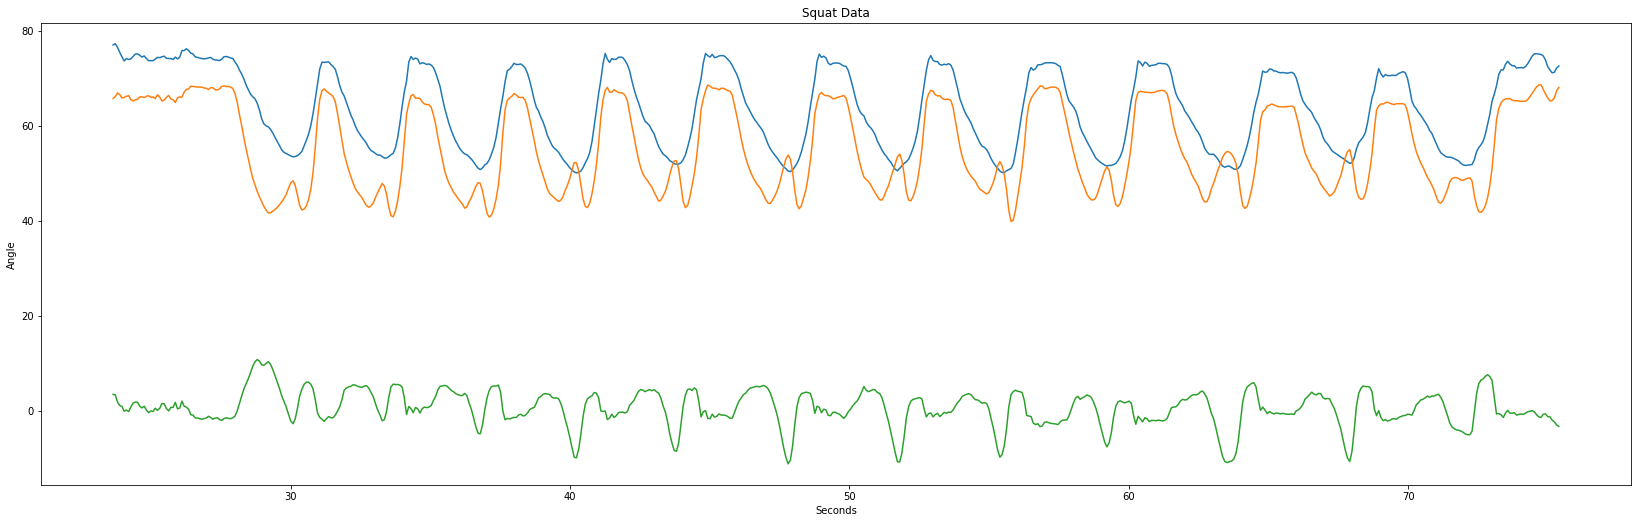

In [5]:

# Collect Data Columns
mS = []
A = []
B = []
Dev = []
with open('Baseline Tests/FW1.0_Base_D_sqbar_12/FW1.0_Base_D_sqbar_12.csv', 'rb') as csvfile:
    data = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in data:
        mS.append(float(row[0]))
        A.append(float(row[1]))
        B.append(float(row[2]))
        Dev.append(float(row[3]))
        

# Timescale in Seconds
t = mS
t = [x /1000 for x in t]

print(len(A))

minx = 200
maxx = 850

#
plt.figure(0)
plt.plot(t[minx:maxx], A[minx:maxx])
plt.plot(t[minx:maxx], B[minx:maxx])
plt.plot(t[minx:maxx], Dev[minx:maxx])
fig = plt.gcf()
plt.xlabel("Seconds")
plt.ylabel("Angle")
fig.set_size_inches(28.5, 8.5)
plt.title("Squat Data")
plt.show()



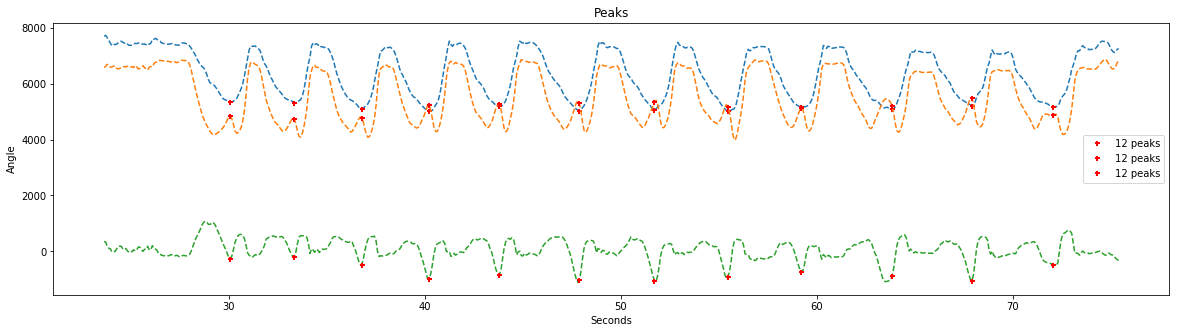

Number of A_reps: 
12
length of one rep:
54
(54L, 12L)


In [7]:
########## PEAK FINDER for REPETITION ID
## Estimate Average Repetition Signal using a simple peak-finder
# similar to "lining up" the periodic signal
#adjust the parameters to make the peakfinder work as will
t_data = np.asarray(t[minx:maxx])

# convert to ints
A_int = [int(x*100) for x in A]
A_int = np.asarray(A_int)
A_int.reshape((1, -1))
# flip to find peaks
A_flip = [-x + (max(A_int[minx:maxx]))for x in A_int[minx:maxx]]
A_flip = np.asarray(A_flip)
A_flip.reshape((1, -1))
# convert to ints
B_int = [int(x*100) for x in B]
B_int = np.asarray(B_int)
B_int.reshape((1, -1))
Dev_int = [int(x*100) for x in Dev]
Dev_int = np.asarray(Dev_int)
Dev_int.reshape((1, -1))

# GET INDICES
indexes = peakutils.indexes(A_flip, thres=0.5, min_dist=40)  
#print(A[minx:maxx])
#print A_indexes     

# PLOT TROUGHS
plt.figure(figsize=(20,5))
pplot(t_data, A_int[minx:maxx], indexes)
pplot(t_data, B_int[minx:maxx], indexes)
pplot(t_data, Dev_int[minx:maxx], indexes)
plt.title('Peaks')
plt.xlabel("Seconds")
plt.ylabel("Angle")
plt.show()


##### Create "average" signal for one repetition

# calculate the average distance between reps
reh = 0
for i in range(len(indexes)-1):
    reh += (indexes[i+1] - indexes[i])

avg_dist = reh/(len(indexes)-1)

# extend x times the length of the period in either direction
Lbuffersize = int(avg_dist*(0.65))
Rbuffersize = int(avg_dist*(0.50))
rep_length = Lbuffersize + Rbuffersize + 1

# extract each repetition from A data
A_reps = np.zeros((len(indexes), rep_length))
for i,index in enumerate(indexes):
    temp = np.arange(index-Lbuffersize,index+Rbuffersize+1)
    A_reps[i,:] = A_int[minx:maxx][temp]
    

# extract each repetition from B data
B_reps = np.zeros((len(indexes), rep_length))
for i,index in enumerate(indexes):
    temp = np.arange(index-Lbuffersize,index+Rbuffersize+1)
    B_reps[i,:] = B_int[minx:maxx][temp]    
   
# extract each repetition from Dev data
Dev_reps = np.zeros((len(indexes), rep_length))
for i,index in enumerate(indexes):
    temp = np.arange(index-Lbuffersize,index+Rbuffersize+1)
    Dev_reps[i,:] = Dev_int[minx:maxx][temp] 
    
    
# transpose repetitions matrix
A_reps = np.transpose(A_reps)
B_reps = np.transpose(B_reps)
Dev_reps = np.transpose(Dev_reps)

print "Number of A_reps: "  
print A_reps.shape[1]
print "length of one rep:"
print rep_length
print A_reps.shape

#plot the repetitions
t_rep = np.linspace(0, rep_length-1, rep_length) #in sample scale
mean_A = np.mean(A_reps, axis = 1)
mean_B = np.mean(B_reps, axis = 1)
mean_Dev = np.mean(Dev_reps, axis = 1)

plt.figure(figsize=(10,5))
plt.plot(t_rep.reshape(-1,1),A_reps,color = 'b')
plt.plot(t_rep.reshape(-1,1),mean_A,color = 'r',linewidth = 4, label = "Mean A Signal")
plt.title("Plot All A Signal")
plt.xlabel("Samples")
plt.ylabel("Angle")
plt.legend()
#plt.show()

#print "A"
#for i in mean_A:
    #print i

plt.figure(figsize=(10,5))
plt.plot(t_rep.reshape(-1,1),B_reps,color = 'b')
plt.plot(t_rep.reshape(-1,1),mean_B,color = 'r',linewidth = 4, label = "Mean B Signal")
plt.title("Plot All B Signal")
plt.xlabel("Samples")
plt.ylabel("Angle")
plt.legend()
#plt.show()

#print "B"
#for i in mean_B:
    #print i

mean_Dev = mean_Dev/100
    
plt.figure(figsize=(10,5))
#plt.plot(t_rep.reshape(-1,1),Dev_reps,color = 'b')
plt.plot(t_rep.reshape(-1,1),mean_Dev,color = 'r',linewidth = 4, label = "Mean Dev Signal")
plt.title("Mean Squat Signal (Subjec 1, Baseline)")
plt.xlabel("Samples")
plt.ylabel("Angle")
plt.legend()
#plt.show()

#print "Dev"
#for i in mean_Dev:
#    print i